# Supervised Algorithms For The Detection Of COVID-19 From Chest CT Scan Images

### Import necessary libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imutils import paths
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

### Resize the image to a fixed size, then flatten the image into a list of raw pixel intensities

In [2]:
def image_to_feature_vector(image):
	return cv2.resize(image, (60, 60)).flatten()

### Extract a 3D color histogram from the HSV color space using the supplied number of `bins` per channel, then perform "in place" normalization in OpenCV, and return the flattened histogram as the feature vector

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 256, 0, 256, 0, 256])
	cv2.normalize(hist, hist)
	return hist.flatten()

### Specify the directory for the CT scan images, then initialize the raw pixel intensities matrix, the features matrix, and labels list

In [4]:
# grab the list of images that we'll be describing
print("[INFO] describing images...")
imagePaths = list(paths.list_images("Images-processed/"))
rawImages = []
features = []
labels = []

[INFO] describing images...


### Loop over the input images:
#### 1) load the image and extract the class label (assuming that our path is in the format: /path/to/dataset/{class}.{image_num}.jpg
#### 2) extract raw pixel intensity "features", followed by a color histogram  to characterize the color distribution of the pixels in the image. 
#### 3) update the raw images, features, and labels matricies, respectively

In [5]:
for (i, imagePath) in enumerate(imagePaths):

	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	pixels = image_to_feature_vector(image)
	hist = extract_color_histogram(image)

	rawImages.append(pixels)
	features.append(hist)
	labels.append(label)
    
	if i > 0 and i % 100 == 0:    # show an update every 100 images
		print("[INFO] processed {}/{}".format(i, len(imagePaths)))
print("[INFO] processed {}/{}".format(i+1, len(imagePaths)))

[INFO] processed 100/2481
[INFO] processed 200/2481
[INFO] processed 300/2481
[INFO] processed 400/2481
[INFO] processed 500/2481
[INFO] processed 600/2481
[INFO] processed 700/2481
[INFO] processed 800/2481
[INFO] processed 900/2481
[INFO] processed 1000/2481
[INFO] processed 1100/2481
[INFO] processed 1200/2481
[INFO] processed 1300/2481
[INFO] processed 1400/2481
[INFO] processed 1500/2481
[INFO] processed 1600/2481
[INFO] processed 1700/2481
[INFO] processed 1800/2481
[INFO] processed 1900/2481
[INFO] processed 2000/2481
[INFO] processed 2100/2481
[INFO] processed 2200/2481
[INFO] processed 2300/2481
[INFO] processed 2400/2481
[INFO] processed 2481/2481


### Show a sample of CT Scan Images

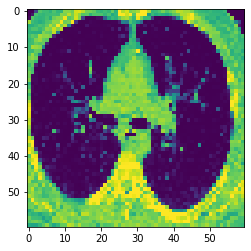

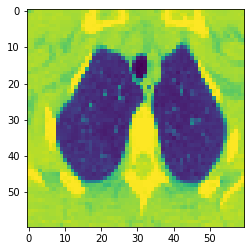

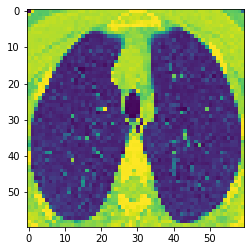

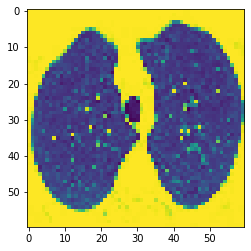

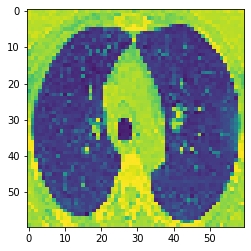

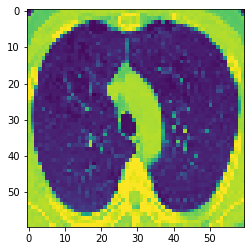

In [6]:
%matplotlib inline
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 6: break
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (60, 60))
    plt.imshow(img)
    plt.show()

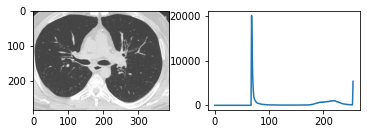

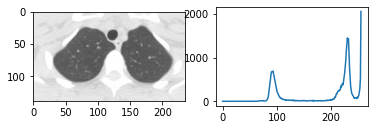

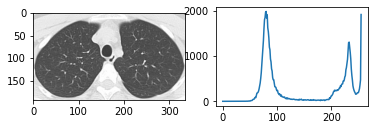

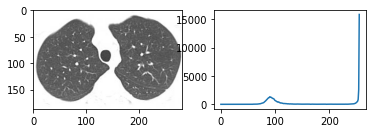

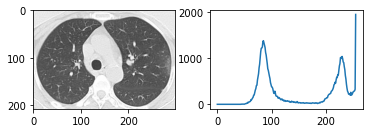

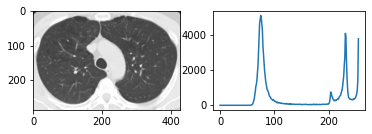

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 6: break
    img = cv2.imread(imagePath)
    hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.subplot(221), plt.imshow(img, 'gray')
    plt.subplot(222), plt.plot(hist_full)
    plt.show()

### Show some information on the memory consumed by the raw images matrix and features matrix

In [14]:
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
	features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 26.17MB
[INFO] features matrix: 4.96MB


### Split partition the data into training and testing splits, using 80% of the data for training and 20% for testing

In [15]:
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.20, random_state=10)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(features, labels, test_size=0.20, random_state=10)

## A. Training the algorithms using the raw images matrix

### Specify the inputs

In [16]:
X = rawImages
y = labels
X_train = trainRI
X_test = testRI
y_train = trainRL
y_test = testRL

### Perform standardization by centering and scaling the training set and the test set

In [17]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Train and evaluate a k-NN classifer on the raw pixel intensities

In [18]:
print("[INFO] evaluating k-NN raw pixel accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print("[INFO] k-NN raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating k-NN raw pixel accuracy...
[INFO] k-NN raw pixel accuracy: 94.37%


### Print the classification report for the k-NN raw pixel model

In [19]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.94      0.95      0.94       238
   NON_COVID       0.95      0.94      0.95       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497



### Train and evaluate a Linear SVM classifer on the raw pixel intensities

In [20]:
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
acc = linear_svc.score(X_test, y_test)
print("[INFO] Linear SVM raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] Linear SVM raw pixel accuracy: 76.86%


### Print the classification report for the Linear SVM raw pixel model

In [21]:
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.77      0.74      0.75       238
   NON_COVID       0.77      0.80      0.78       259

    accuracy                           0.77       497
   macro avg       0.77      0.77      0.77       497
weighted avg       0.77      0.77      0.77       497



### Train and evaluate an SVM classifer on the raw pixel intensities using the RBF kernel then print the classification report for the model

### 1) using C parameter = 10

In [22]:
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 'scale')
rbf_svc.fit(X_train, y_train)
acc = rbf_svc.score(X_test, y_test)
print("[INFO] RBF SVM raw pixel accuracy with C=10: {:.2f}%".format(acc * 100))

[INFO] RBF SVM raw pixel accuracy with C=10: 95.98%


In [23]:
y_pred = rbf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.97      0.95      0.96       238
   NON_COVID       0.95      0.97      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497



### 2) using C parameter = 1

In [24]:
rbf_svc = svm.SVC(kernel='rbf', C = 1, gamma = 'scale')
rbf_svc.fit(X_train, y_train)
acc = rbf_svc.score(X_test, y_test)
print("[INFO] RBF SVM raw pixel accuracy with C=1: {:.2f}%".format(acc * 100))

[INFO] RBF SVM raw pixel accuracy with C=1: 92.15%


In [25]:
y_pred = rbf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.93      0.90      0.92       238
   NON_COVID       0.91      0.94      0.93       259

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497



### 3) using C parameter = 0.1

In [26]:
rbf_svc = svm.SVC(kernel='rbf', C = 0.1, gamma = 'scale')
rbf_svc.fit(X_train, y_train)
acc = rbf_svc.score(X_test, y_test)
print("[INFO] RBF SVM raw pixel accuracy with C=0.1: {:.2f}%".format(acc * 100))

[INFO] RBF SVM raw pixel accuracy with C=0.1: 79.68%


In [27]:
y_pred = rbf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.84      0.71      0.77       238
   NON_COVID       0.77      0.87      0.82       259

    accuracy                           0.80       497
   macro avg       0.80      0.79      0.79       497
weighted avg       0.80      0.80      0.80       497



### B. Training the algorithms using the features matrix (extracted color histogram)

### Specify the inputs

In [28]:
X = features
y = labels
X_train = trainFeat
X_test = testFeat
y_train = trainLabels
y_test = testLabels

### Perform standardization by centering and scaling the training set and the test set

In [29]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

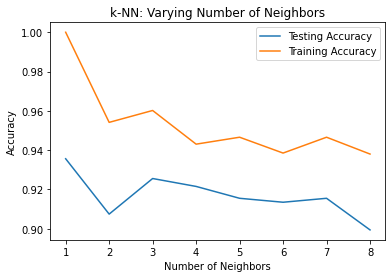

In [30]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the color histogram representations

In [31]:
print("[INFO] evaluating histogram accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print("[INFO] k-NN histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating histogram accuracy...
[INFO] k-NN histogram accuracy: 92.56%


### Print the classification report for the k-NN histogram model

In [32]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.90      0.95      0.92       238
   NON_COVID       0.95      0.91      0.93       259

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497



### Train and evaluate a Linear SVM classifer on the color histogram representations

In [45]:
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
acc = linear_svc.score(X_test, y_test)
print("[INFO] Linear SVM histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] Linear SVM histogram accuracy: 86.72%


### Print the classification report for the Linear SVM histogram model

In [46]:
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.92      0.79      0.85       238
   NON_COVID       0.83      0.93      0.88       259

    accuracy                           0.87       497
   macro avg       0.87      0.86      0.87       497
weighted avg       0.87      0.87      0.87       497



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the color histogram representations and print the classification report for the model

In [37]:
steps = [('scaler', StandardScaler()),
         ('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("[INFO] RBF SVM histogram accuracy: {:.2f}%".format(cv.score(X_test, y_test)*100))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

[INFO] RBF SVM histogram accuracy: 93.96%
              precision    recall  f1-score   support

       COVID       0.94      0.94      0.94       238
   NON_COVID       0.94      0.94      0.94       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 1}


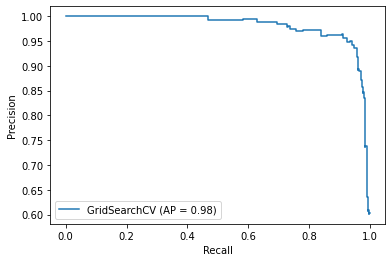

In [43]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
disp = plot_precision_recall_curve(cv, X_test, y_test)